# 1. Load dataset

In [1]:
import sys
import pandas as pd
sys.path.append('../EDA/analysis-tools')
from analysis_tools.common.utils import *
from analysis_tools import utils, random, eda

train = pd.read_csv('../../data/train_fe_with_lag.csv')
test = pd.read_csv('../../data/test.csv')

# 2. Construct dataset for modeling

In [2]:
from tensorflow import keras
from tensorflow.keras.utils import timeseries_dataset_from_array
from analysis_tools import preprocessing

def print_shape(*args):
    print("* Shape of dataset")
    for arg in args:
        print(f"  - {arg.shape}")

def drop_missing_data(inp_prev, out_prev):
    inp_after, out_after = [], []
    for inp, out in zip(inp_prev, out_prev):
        if (np.isnan(inp).sum() == 0) and (np.isnan(out).sum() == 0):
            inp_after.append(inp)
            out_after.append(out)
    return np.array(inp_after), np.array(out_after)

def sliding_window(df, in_seq_len, out_seq_len, stride):
    inp_df = df.iloc[:-out_seq_len]
    out_df = df.iloc[in_seq_len:]

    inps = []
    outs = []
    for i in range(0, len(df) - in_seq_len - out_seq_len + 1, stride):
        inp = inp_df.iloc[i:i + in_seq_len]
        out = out_df.iloc[i:i + out_seq_len]
        if (inp.isnull().values.any()) or (out.isnull().values.any()):
            continue
        inps.append(inp.values)
        outs.append(out.values)
    return np.array(inps), np.array(outs)

def windows_from_dataframe(df, in_seq_len, out_seq_len, stride):
    df = df.astype('float32')
    if len(df) == in_seq_len:  # test dataframe
        inp = [df.values]  # expand_dim
        out = None
        inp, _ = drop_missing_data(inp, inp)
    else:
        inp, out = sliding_window(df, in_seq_len, out_seq_len, stride)
        inp, out = drop_missing_data(inp, out)
    return inp, out

def scale(data, scaler):
    if not isinstance(data, np.ndarray):
        data = np.array(data, dtype='float32')
    if len(data.shape) == 3:
        return scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    elif len(data.shape) == 2:
        return scaler.transform(data)
    else:
        raise ValueError("len(data.shape) should be 2 or 3")
        
def inverse_scale(data, scaler):
    if len(data.shape) == 3:
        return scaler.inverse_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    elif len(data.shape) == 2:
        return scaler.inverse_transform(data)
    else:
        raise ValueError("len(data.shape) should be 2 or 3")

In [3]:
def get_idxs_abnormal(data):
    cond1 = (data['Patv'] <= 0) & (data['Wspd'] > 2.5)
    cond2 = (data['Pab1'] > 89) | (data['Pab2'] > 89) | (data['Pab3'] > 89)
    cond3 = (data['Wdir'] < -180) | (data['Wdir'] > 180) | (data['Ndir'] < -720) | (data['Ndir'] > 720)
    cond4 = data['Patv'].isnull()
    cond  = cond1 | cond2 | cond3 | cond4
    return np.where(cond)[0], np.where(cond1)[0], np.where(cond2)[0], np.where(cond3)[0], np.where(cond4)[0]

def mark_abnormal_Patv(data):
    data = copy(data)
    data['Abnormal'] = 0
    data[[f'Abnormal_{i}' for i in [1, 2, 3, 4]]] = 0
    idxs_full, idxs_1, idxs_2, idxs_3, idxs_4 = get_idxs_abnormal(data)
    for num, i in enumerate([idxs_1, idxs_2, idxs_3, idxs_4], start=1):
        data.loc[data.iloc[i].index, f'Abnormal_{num}'] = 1
    data.loc[data.iloc[idxs_full].index, 'Abnormal'] = 1
    
#     # Plot
#     fig, axes = plt.subplots(5, figsize=(40, 8))
#     for ax, col in zip(axes, ['Abnormal'] + [f'Abnormal_{i}' for i in [1, 2, 3, 4]]):
#         sns.boxplot(x='Patv', y=col, data=data, orient='h', ax=ax);
#     for ax in axes[:-1]:
#         ax.set_xticklabels([])
#         ax.set_xlabel(None)        

    # Adjust Patv
    data['Patv'] = data['Patv'].where(data['Abnormal_2'] == 0, 0)
    data['Patv'] = data['Patv'].where(data['Abnormal_3'] == 0, 0)

    data['Ndir'] = np.clip(data['Ndir'], -720, 720)
    data['Wdir'] = np.clip(data['Wdir'], -180, 180)
    for i in [1, 2, 3]:
        data[f'Pab{i}'] = np.clip(data[f'Pab{i}'], 0, 89)
    
    return data

In [4]:
target = 'Patv'
cols  = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab', 'Prtv', 'RPM', target]
cols += ['Wdir_extreme', 'Wdir_comb', 'Ndir_cos_abs', 'Ndir_extreme', 'Pab_extreme1', 'Pab_extreme2', 'Prtv_pos', 'Prtv_abs', 'Prtv_comb', 'Wspd_cube', 'Patan_abs']

cols_inp     = cols
cols_out     = [target]
cols_out_raw = [target]

cols         = list((set(cols_inp) | set(cols_out)) - {target}) + [target]
idx_cols_inp = [cols.index(col) for col in cols_inp]
idx_cols_out = [cols.index(col) for col in cols_out]

input_days  = 2
IN_SEQ_LEN  = input_days*144
OUT_SEQ_LEN = 2*144
STRIDE      = 2*144

tids   = train['TurbID'].unique()
n_tids = len(tids)

train_inp, train_out = n_tids*[None], n_tids*[None]
val_inp,   val_out   = n_tids*[None], n_tids*[None]
test_inp,  test_out  = n_tids*[None], n_tids*[None]

days       = sorted(train['Day'].unique())
train_data = train[train['Day'].isin(days[:-input_days-30])]
val_data   = train[train['Day'].isin(days[-input_days-30:-input_days])]
test_data  = train[train['Day'].isin(days[-input_days:])]
test_data_raw_mark = mark_abnormal_Patv(test)

In [8]:
for i, tid in tqdm(list(enumerate(tids))):
    d_train = train_data.loc[train_data['TurbID'] == tid, cols]
    d_val   = val_data.loc[val_data['TurbID'] == tid, cols]
    d_test  = test_data.loc[test_data['TurbID'] == tid, cols]
    
    train_inp[i], train_out[i] = windows_from_dataframe(d_train, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    val_inp[i],   val_out[i]   = windows_from_dataframe(d_val, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    test_inp[i],  _            = windows_from_dataframe(d_test, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    test_out[i] = [test_data_raw_mark.query(f"TurbID == {tid}")[cols_out_raw].values]
    
train_inp = np.concatenate(train_inp)[..., idx_cols_inp]
train_out = np.concatenate(train_out)[..., idx_cols_out]

val_inp = np.concatenate(val_inp)[..., idx_cols_inp]
val_out = np.concatenate(val_out)[..., idx_cols_out]

test_inp = np.concatenate(test_inp)[..., idx_cols_inp]
test_out = np.concatenate(test_out)

print_shape(train_inp, train_out, val_inp, val_out, test_inp, test_out)

100%|██████████| 134/134 [00:05<00:00, 22.82it/s]


* Shape of dataset
  - (10184, 288, 20)
  - (10184, 288, 1)
  - (1876, 288, 20)
  - (1876, 288, 1)
  - (134, 288, 20)
  - (134, 288, 1)


# 3. Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_inp = MinMaxScaler()
scaler_inp.fit(train_inp.reshape(-1, train_inp.shape[-1]))
train_inp_scale = scale(train_inp, scaler_inp)
val_inp_scale   = scale(val_inp, scaler_inp)
test_inp_scale  = scale(test_inp, scaler_inp)

scaler_out = MinMaxScaler()
scaler_out.fit(train_out.reshape(-1, train_out.shape[-1]))
train_out_scale = scale(train_out, scaler_out)
val_out_scale   = scale(val_out, scaler_out)
test_out_scale  = scale(test_out, scaler_out)

input_shape  = train_inp.shape[1:]
output_shape = train_out.shape[1:]
print_shape(train_inp_scale, train_out_scale,
            val_inp_scale, val_out_scale,
            test_inp_scale, test_out_scale)

* Shape of dataset
  - (10184, 288, 20)
  - (10184, 288, 1)
  - (1876, 288, 20)
  - (1876, 288, 1)
  - (134, 288, 20)
  - (134, 288, 1)


# 4. DataLoader

In [11]:
from analysis_tools import modeling

BATCH_SIZE  = 32
SHUFFLE     = True

train_ds = modeling.generate_dataset_tf(train_inp_scale, train_out_scale, BATCH_SIZE, SHUFFLE)
val_ds   = modeling.generate_dataset_tf(val_inp_scale, val_out_scale, BATCH_SIZE, shuffle=False)
test_ds  = modeling.generate_dataset_tf(test_inp_scale, test_out_scale, BATCH_SIZE, shuffle=False)

2022-12-04 19:37:32.254832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 19:37:32.256233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 19:37:32.256931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 19:37:32.258891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# 5. GRU

In [12]:
from tensorflow.keras import layers
    
def build_model(input_shape, output_shape, units, n_blocks, dropout=None):
    S,  D  = input_shape
    S_, D_ = output_shape
    
    model = keras.Sequential(name="GRU-Model") # Model
    model.add(keras.Input(shape=(S, D), name='Input-Layer'))
    
    for _ in range(n_blocks):
        model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True)))  # , kernel_regularizer='l2'
        
    model.add(layers.Dense(units=D_))  # , kernel_regularizer='l2'
    return model

In [23]:
import tensorflow as tf
from tensorflow.keras import losses, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras
    
class CondLoss(losses.Loss):
    def __init__(self, loss_fn, cols_out, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
        self.cols_out = cols_out
        if 'Abnormal' in self.cols_out:
            self.idx_abnormal = cols_out.index('Abnormal')
            self.idx_target   = cols_out.index(target)
    def call(self, y_true, y_pred):
        _, S_, D_ = y_true.shape
        
        y_true = tf.reshape(y_true, (-1, D_))
        y_pred = tf.reshape(y_pred, (-1, D_))
        
        if 'Abnormal' in self.cols_out:
            Abnormal_true, Patv_true = tf.split(y_true, D_, axis=1)
            Abnormal_pred, Patv_pred = tf.split(y_pred, D_, axis=1)
            res = tf.where(tf.equal(Abnormal_true, 1), tf.constant(0, dtype=tf.float32), Patv_true - Patv_pred)
        else:
            res = y_true - y_pred
    
        if self.loss_fn == 'rmse':
            return tf.sqrt(tf.reduce_mean(tf.square(res)))
        elif self.loss_fn == 'mse':
            return tf.reduce_mean(tf.square(res))
        elif self.loss_fn == 'mae':
            return tf.reduce_mean(tf.abs(res))
        else:
            raise NotImplementedError
            
def compile_and_fit(model, train_ds, val_ds, epochs, patience_es=10, patience_lr=3):
    model.compile(optimizers.Adam(1e-4), loss=CondLoss('rmse', cols_out))
    os.makedirs('/root/workspace/modeling/GRU_ckpt', exist_ok=True)
    return model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=patience_es, restore_best_weights=True),
                        ReduceLROnPlateau(patience=patience_lr),
                        ModelCheckpoint(join('/root/workspace/modeling/GRU_ckpt', '[{epoch:03d} epoch].h5'), save_best_only=False, save_weights_only=True),
                    ])

In [24]:
model = build_model(input_shape, output_shape, units=64, n_blocks=2, dropout=0.1)
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 288, 128)         33024     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 288, 128)         74496     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 288, 1)            129       
                                                                 
Total params: 107,649
Trainable params: 107,649
Non-trainable params: 0
_________________________________________________________________


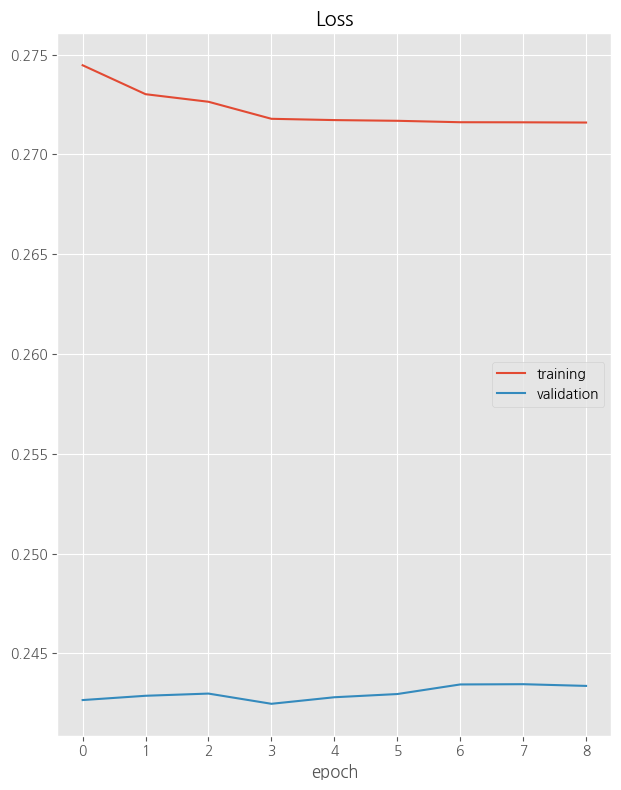

Loss
	training         	 (min:    0.272, max:    0.274, cur:    0.272)
	validation       	 (min:    0.242, max:    0.243, cur:    0.243)
319/319 [==============================] - 10s 33ms/step - loss: 0.2716 - val_loss: 0.2434 - lr: 1.0000e-07


In [25]:
compile_and_fit(model, train_ds, val_ds, epochs=20, patience_es=5, patience_lr=2)

# 6. Result

### - Trainig, Validation set

In [26]:
def plot_result(model, scaler_inp, scaler_out, cols_inp, cols_out, datasets, n_cols=5, figsize=(40, 20)):
    def metric(y, p, cols_out):
        B, S_, D_ = y.shape
        
        y = tf.reshape(y, (-1, D_)).numpy()
        p = tf.reshape(p, (-1, D_)).numpy()
        
        if 'Abnormal' in cols_out:
            idxs_valid = np.where(y[:, cols_out.index('Abnormal')].reshape(-1) == 1)[0]
            res = y[idxs_valid] - p[idxs_valid]
        else:
            res = y-p
        res = res[~np.isnan(res)]
        return (np.abs(res).mean() + np.sqrt((res**2).mean()))/2
    
    for name, ds in datasets.items():
        outs_scale = []
        p_outs_scale = []
        for in_scale, out_scale in ds.as_numpy_iterator():
            p_out_scale = model.predict(in_scale, verbose=0)
            outs_scale.append(out_scale);  p_outs_scale.append(p_out_scale)
        
        outs_scale = np.concatenate(outs_scale)
        p_outs_scale = np.concatenate(p_outs_scale)

        outs = inverse_scale(outs_scale, scaler_out)
        p_outs = inverse_scale(p_outs_scale, scaler_out)
        print(f"[{name}] mean(MAE, RMSE): {metric(outs, p_outs, cols_out):.2f}")
        
        for inp, out in ds.take(1):
            inp   = inp[:n_cols]
            out   = out[:n_cols]
            p_out = model.predict(inp, verbose=0)
            
        inps   = [pd.DataFrame(inverse_scale(d, scaler_inp), columns=cols_inp, dtype='float32') for d in inp]
        outs   = [pd.DataFrame(inverse_scale(d, scaler_out), columns=cols_out) for d in out]
        p_outs = [pd.DataFrame(inverse_scale(d, scaler_out), columns=cols_out) for d in p_out]
        
        n_rows = out.shape[-1]
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if axes.ndim == 1:
            axes = [axes]
        for ax_col, col in zip(axes, cols_out):
            for idx_row, (ax, out, p_out) in enumerate(zip(ax_col, outs, p_outs)):
                ax.plot(out[col], label='true')
                ax.plot(p_out[col], label=f'pred ({np.mean(abs(p_out[col]-out[col])):.3f})')
                ax.fill_between(range(len(out[col])), out[col], p_out[col], alpha=0.1, color='b')
                ax.set_xticklabels([])
                ax.legend()
                if idx_row == 0:
                    ax.set_ylabel(col)
        fig.tight_layout()
        plt.show()

[train] mean(MAE, RMSE): 385.20


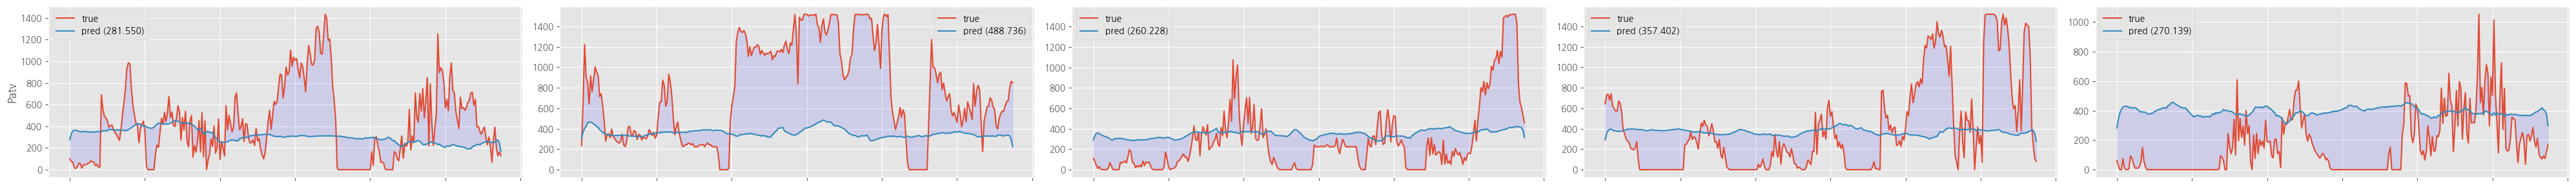

[val] mean(MAE, RMSE): 347.95


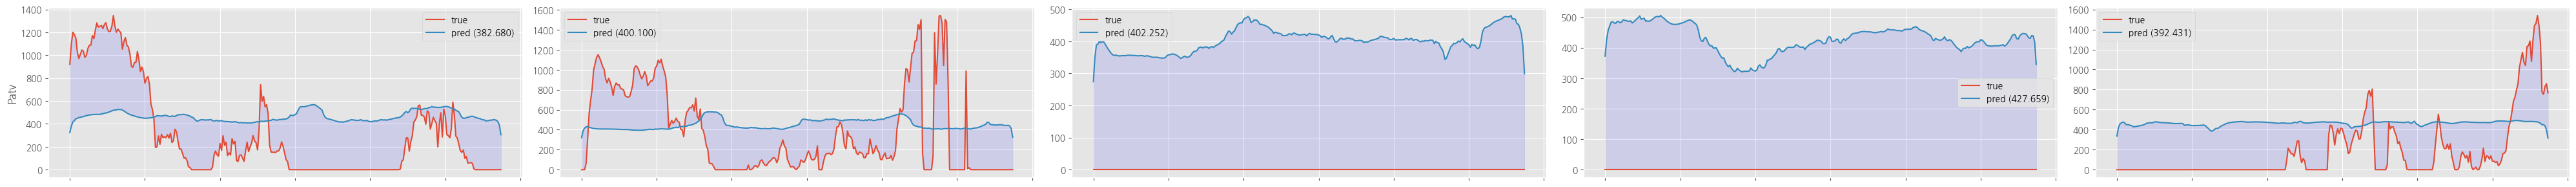

In [27]:
plot_result(model, scaler_inp, scaler_out, cols_inp, cols_out, {'train': train_ds, 'val': val_ds}, figsize=(40, 3))

### - Test set

[test] mean(MAE, RMSE): 529.35


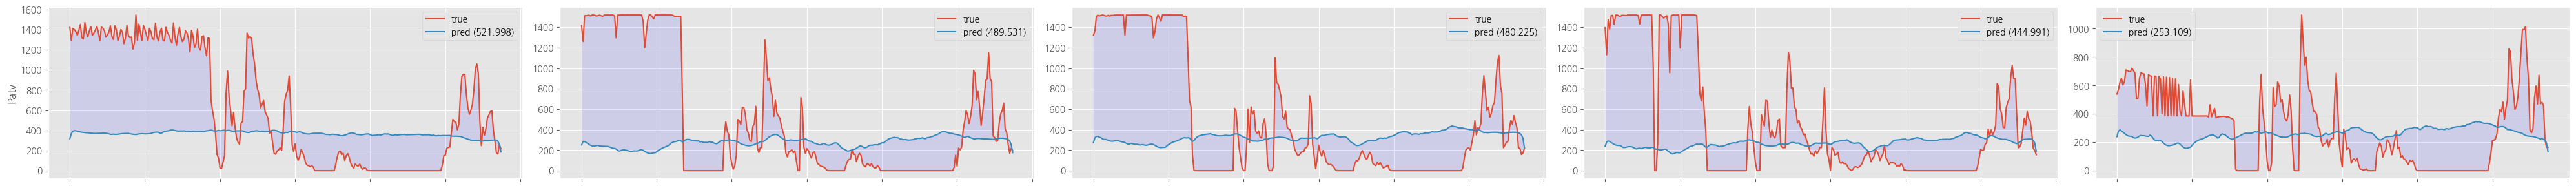

In [28]:
plot_result(model, scaler_inp, scaler_out, cols_inp, cols_out, {'test': test_ds}, figsize=(40, 3))